In [54]:
from scipy import *
import numpy as np
from scipy.stats import rankdata
import h5py, WLanalysis
%matplotlib inline

In [35]:
mnu, N = 0.0, 66
ID, Mvir0, Vmax, Rvir, Rs, x, y, z, Spin, PID0 = load('cat/mnv_0.6_66_parents.npy').T
idx = where( (PID0==-1) & (Mvir0>=10**12))[0]
ID, Mvir, Vmax, Rvir, Rs, x, y, z, Spin, PID = load('cat/mnv_0.6_66_parents.npy')[idx,:].T
Cvir=Rvir/Rs

In [36]:
print len(PID),sum(PID==-1), sum(PID!=-1)

530696 530696 0


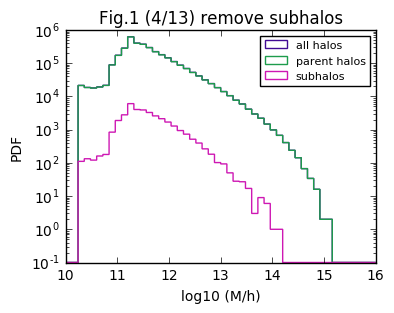

In [37]:
seed(68)
ibins=linspace(10, 16, 51)
f, ax=subplots(1,1,figsize=(4,3))
ax.hist(log10(Mvir0),bins=ibins,label='all halos', 
        histtype='step',log=1,color=rand(3))
ax.hist(log10(Mvir0[PID0==-1]),bins=ibins,label='parent halos', 
        histtype='step',log=1,color=rand(3))
ax.hist(log10(Mvir0[PID0!=-1]),bins=ibins,label='subhalos', 
        histtype='step',log=1,color=rand(3))
ax.legend(fontsize=8,loc=0)
ax.set_xlabel('log10 (M/h)')
ax.set_ylabel('PDF')
ax.set_title('Fig.1 (4/13) remove subhalos')
show()

In [38]:
logM = log10(Mvir)
Mcut=13.5
logMbins0 = percentile(logM[ (logM>=12.0) & (logM<Mcut)], linspace(0,100,101))
logMbins1 = percentile(logM[(logM>=Mcut) & (logM<15.5)], linspace(0,100,51))
logMbins = concatenate( [logMbins0, logMbins1])
print unique(logMbins0).shape, unique(logMbins1).shape

(101,) (51,)


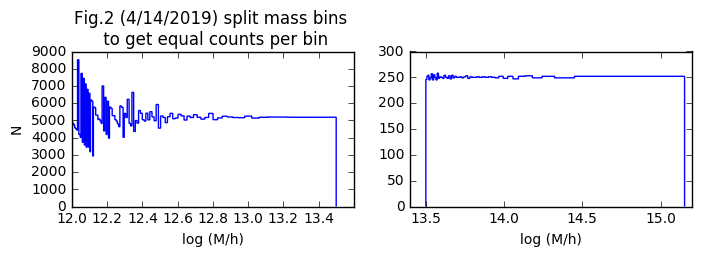

In [39]:
f, (ax1,ax2) = subplots(1,2, figsize=(8,2))
ax1.hist(logM, bins=logMbins0, histtype='step')
ax2.hist(logM, bins=logMbins1, histtype='step')
ax1.set_xlabel('log (M/h)')
ax2.set_xlabel('log (M/h)')
ax1.set_ylabel('N')
ax1.set_title('Fig.2 (4/14/2019) split mass bins \n to get equal counts per bin')
show()

In [40]:
## Cvir, Vmax, Spin
Cvir_mark = zeros(Mvir.shape)
Vmax_mark = zeros(Mvir.shape)
Spin_mark = zeros(Mvir.shape)

for i in range(len(logMbins)-1):
    iidx=where( (logM>=logMbins[i]) & (logM<logMbins[i+1]))[0]
    Cvir_mark[iidx] = rankdata(Cvir[iidx])/len(iidx)
    Vmax_mark[iidx] = rankdata(Vmax[iidx])/len(iidx)
    Spin_mark[iidx] = rankdata(Spin[iidx])/len(iidx)

In [41]:
print logM.shape, Cvir.shape, Vmax.shape, Spin.shape
print Cvir_mark.shape, Vmax_mark.shape, Spin_mark.shape

(530696,) (530696,) (530696,) (530696,)
(530696,) (530696,) (530696,)


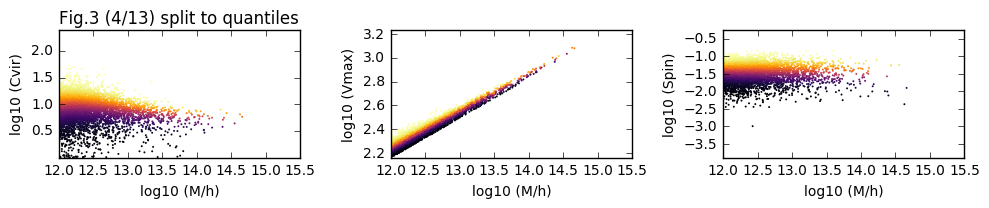

In [42]:
f, axes = subplots(1,3, figsize=(10,2))
iidx=choice(len(Cvir), len(Cvir)/100, replace=0)
for i in range(3):
    ix=log10([Cvir, Vmax, Spin][i])
    imark=[Cvir_mark, Vmax_mark, Spin_mark][i]
    axes[i].scatter(logM[iidx], ix[iidx], s=2, edgecolors='none', 
                      c=imark[iidx], cmap='inferno')
    axes[i].set_xlim(12, 15.5)
    axes[i].set_ylim(amin(ix), amax(ix))
    axes[i].set_xlabel('log10 (M/h)')
    axes[i].set_ylabel('log10 (%s)'%(['Cvir', 'Vmax', 'Spin'][i]))
plt.tight_layout()
axes[0].set_title('Fig.3 (4/13) split to quantiles')
show()

In [149]:
Lbox = 512.0 #Mpc/h
Ngrid = 256.0
ibins=arange(Ngrid)
Lgrid = Lbox/Ngrid
dataset_name='Subsample'
Nbin=15
def gridding (pos):
    grid = histogramdd(pos/Lbox*Ngrid,bins=[ibins,ibins,ibins])[0]
    grid = grid/mean(grid) - 1.0
    return grid

def PS (pos1, pos2, dogrid=1):
    if dogrid:
        grid1 = gridding(pos1)
        grid2 = gridding(pos2)
    else:
        grid1, grid2 = pos1, pos2
    k, ps3d = WLanalysis.CrossPowerSpectrum3D(grid1, grid2, bins=Nbin)
    return 2*pi*k/Lbox, ps3d*(Lgrid/Ngrid)**3


def Phm_gen (mnu, N, Mcut=14.0, Mcutlo=13.5, Nbin=15): ## position of halo and particle, in unit of Mpc/h

    ########### particles
    subsample_fn = 'snapshot_mnv_%.1f/snapshot_%03d_idmod_101_0.hdf5'%(mnu,N)
    f=h5py.File(subsample_fn,'r')
    dataset = f[dataset_name]
    particle_pos = dataset['Position']/1e3
    gridP = gridding(particle_pos)
    k, Pmm = PS(gridP, gridP, dogrid=0)    

    ########### halos
    ID, Mvir0, Vmax, Rvir, Rs, x, y, z, Spin, PID0 = load('cat/mnv_%.1f_%02d_parents.npy'%(mnu,N)).T
    idx = where( (PID0==-1) & (Mvir0>=10**12))[0]
    ID, Mvir, Vmax, Rvir, Rs, x, y, z, Spin, PID = load('cat/mnv_%.1f_%02d_parents.npy'%(mnu,N))[idx,:].T
    Cvir=Rvir/Rs
    logM = log10(Mvir)
    halo_pos =array([x,y,z]).T
    k, Phm12 = PS(gridP, gridding(halo_pos[logM<Mcutlo]), dogrid=0)
    k, Phm14 = PS(gridP, gridding(halo_pos[logM>=Mcut]), dogrid=0)
    
    ## shot noise
    Npart = len(particle_pos)
    Nmm = Lbox**3/Npart
    Nhm12 = Lbox**3/sqrt(Npart)/sqrt(sum(logM<Mcutlo))
    Nhm14 = Lbox**3/sqrt(Npart)/sqrt(sum(logM>=Mcut))
    
    ####### for each AB property, compute for 
    ##### 2 halo masses, 2 splits (top half, bottom half), so 4 combinations
    
    logMbins0 = percentile(logM[ (logM>=12.0) & (logM<Mcutlo)], linspace(0,100,101))
    logMbins1 = percentile(logM[(logM>=Mcut) & (logM<15.5)], linspace(0,100,51))
    logMbins = unique(concatenate( [logMbins0, logMbins1]))
    
    out_AB_M12=zeros((3,2,Nbin))
    out_AB_M14=zeros((3,2,Nbin))
    Nhm_M12 = zeros((3,2))
    Nhm_M14 = zeros((3,2))
    i=0
    for ix in (Cvir, Vmax, Spin):
        print i
        ix_mark = zeros(logM.shape)
        for j in range(len(logMbins)-1): ####### put in mark for each mass bin
            iidx=where( (logM>=logMbins[j]) & (logM<logMbins[j+1]))[0]
            ix_mark[iidx] = rankdata(ix[iidx])/len(iidx)
        k, iPhm14hi = PS(gridP, gridding(halo_pos[(logM>=Mcut) & (ix_mark>=0.5)]), dogrid=0)
        k, iPhm14lo = PS(gridP, gridding(halo_pos[(logM>=Mcut) & (ix_mark<0.5)]), dogrid=0)
        k, iPhm12hi = PS(gridP, gridding(halo_pos[(logM<Mcutlo) & (ix_mark>=0.5)]), dogrid=0)
        k, iPhm12lo = PS(gridP, gridding(halo_pos[(logM<Mcutlo) & (ix_mark<0.5)]), dogrid=0)   
        out_AB_M12[i]=[iPhm12hi,iPhm12lo]
        out_AB_M14[i]=[iPhm14hi,iPhm14lo] 
        Nhm_M14[i,0]= Lbox**3/sqrt(Npart)/sqrt(sum((logM>=Mcut) & (ix_mark>=0.5)))                  
        Nhm_M14[i,1]= Lbox**3/sqrt(Npart)/sqrt(sum((logM>=Mcut) & (ix_mark<0.5)))                  
        Nhm_M12[i,0]= Lbox**3/sqrt(Npart)/sqrt(sum((logM<Mcutlo) & (ix_mark>=0.5)))
        Nhm_M12[i,1]= Lbox**3/sqrt(Npart)/sqrt(sum((logM<Mcutlo) & (ix_mark<0.5)))
        i+=1
    return k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], out_AB_M12, out_AB_M14, Nhm_M12, Nhm_M14

In [150]:
# out = Phm_gen(0.0, 66)
# k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], out_AB_M12, out_AB_M14, Nhm_M12, Nhm_M14 = out
# save('Pks_mnu%.1f_%i.npy'%(mnu,N),out)

0.0 66
0
1
2


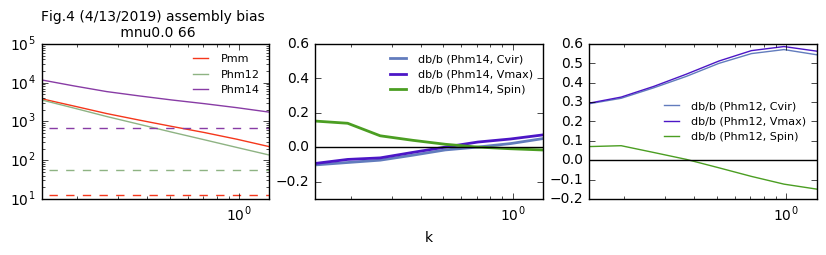

0.0 56
0
1
2


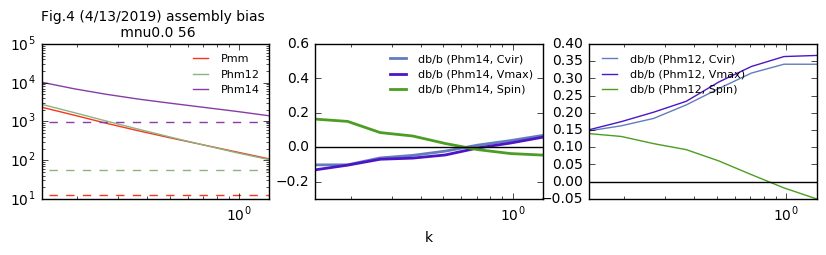

0.0 47
0
1
2


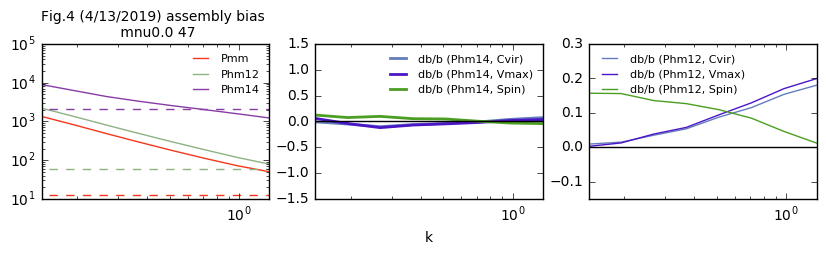

0.0 42
0


ERROR: KeyboardInterrupt [scipy.fftpack.basic]


KeyboardInterrupt: 

In [152]:
for mnu in (0.0, 0.1, 0.6):
    for N in (66, 56, 47, 42, 37):
        print mnu, N
        out = Phm_gen(mnu, N)
        save('Pks_mnu%.1f_%i.npy'%(mnu,N),out)

        k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], out_AB_M12, out_AB_M14, Nhm_M12, Nhm_M14 = out

        seed(808)
        f, (ax,ax4,ax2) = subplots(1,3,figsize=(10,2))
        icolor=rand(20,3)
        ax.plot(k,Pmm,'-',color=icolor[0],label='Pmm')
        ax.plot(k,Phm12,'-',color=icolor[1],label='Phm12')
        ax.plot(k,Phm14,'-',color=icolor[2],label='Phm14')
        ax.plot(k,ones(len(k))*Nmm,'--',color=icolor[0])
        ax.plot(k,ones(len(k))*Nhm12,'--',color=icolor[1])
        ax.plot(k,ones(len(k))*Nhm14,'--',color=icolor[2])

        for j in range(3):
            ilabel=['Cvir','Vmax', 'Spin'][j]
            ax4.plot(k,(out_AB_M14[j, 0]-out_AB_M14[j, 1])/Phm14,'-',lw=2,color=icolor[3+j],label='db/b (Phm14, %s)'%(ilabel))

        for j in range(3):
            ilabel=['Cvir','Vmax', 'Spin'][j]
            ax2.plot(k,(out_AB_M12[j, 0]-out_AB_M12[j, 1])/Phm12,'-',lw=1,color=icolor[3+j],label='db/b (Phm12, %s)'%(ilabel))

        ax.set_xscale('log');ax.set_yscale('log')
        ax2.set_xscale('log');ax4.set_xscale('log');

        ax.set_xlim(k[7],k[-1])
        ax2.set_xlim(k[7],k[-1])
        ax2.plot(k,zeros(len(k)),'k-')
        ax4.set_xlim(k[7],k[-1])
        ax4.plot(k,zeros(len(k)),'k-')
        ax4.set_xlabel('k')

        ax.legend(frameon=0, fontsize=8, loc=0)
        ax2.legend(frameon=0, fontsize=8, loc=0)
        ax4.legend(frameon=0, fontsize=8, loc=0)
        ax.set_title('Fig.4 (4/13/2019) assembly bias \n mnu%s %i'%(mnu, N), fontsize=10)
        show()